#  Post-Event Inference - Video Anomaly Detection
## Batch Processing untuk Analisis CCTV Recordings

Notebook ini untuk:
- **Post-event analysis**: Process video recordings setelah event terjadi
- **Batch processing**: Process multiple videos secara efisien
- **Report generation**: Generate detailed reports dengan timestamps
- **Suitable untuk production**: Realistic deployment scenario

---

##  Use Case: CCTV Surveillance System

```
CCTV Recording (24/7)
        ↓
Scheduled Processing (setiap 10-15 menit)
        ↓
Model Inference (batch)
        ↓
Anomaly Detection
        ↓
Alert + Report
        ↓
Security Operator Review
```

---
## 1️ Setup & Configuration

In [1]:
# =============================================================================
# Import Libraries
# =============================================================================
import os
import sys
import json
import time
import warnings
import random
from pathlib import Path
from datetime import datetime, timedelta
from typing import List, Dict, Optional

import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from ultralytics import YOLO

warnings.filterwarnings('ignore')

print('✅ Libraries imported')

c:\Users\MAHARDIKA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Libraries imported


In [2]:
# =============================================================================
# Paths Configuration
# =============================================================================
NB_ROOT = Path(os.getcwd())
ROOT = NB_ROOT / 'DatasetTA'

RAW_DIR = ROOT / 'project_data' / 'raw'
MODELS_DIR = ROOT / 'project_data' / 'models'
OUTPUT_DIR = ROOT / 'project_data' / 'post_event_results'
REPORTS_DIR = OUTPUT_DIR / 'reports'
VIDEOS_DIR = OUTPUT_DIR / 'annotated_videos'

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
VIDEOS_DIR.mkdir(parents=True, exist_ok=True)

# Model paths
YOLO_MODEL = NB_ROOT / 'yolov8n.pt'
ANOMALY_MODEL = MODELS_DIR / 'best_model.pt'

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
USE_AMP = torch.cuda.is_available()

print('='*60)
print('⚙️ POST-EVENT INFERENCE SETUP')
print('='*60)
print(f'Device: {DEVICE}')
print(f'Raw Videos: {RAW_DIR}')
print(f'Output: {OUTPUT_DIR}')
print(f'YOLO Model: {YOLO_MODEL.exists()}')
print(f'Anomaly Model: {ANOMALY_MODEL.exists()}')
print('='*60)

⚙️ POST-EVENT INFERENCE SETUP
Device: cpu
Raw Videos: c:\Kuliah\TA\TA BARU\DatasetTA\project_data\raw
Output: c:\Kuliah\TA\TA BARU\DatasetTA\project_data\post_event_results
YOLO Model: True
Anomaly Model: True


In [3]:
# =============================================================================
# Processing Configuration
# =============================================================================
class Config:
    """Configuration for post-event processing"""
    
    # Video processing
    FRAME_SKIP = 2          # Process every N frames
    BUFFER_SIZE = 240       # Frames per segment (8 seconds @ 30fps)
    SEGMENT_SIZE = 8        # Number of segments
    
    # Graph construction
    MAX_NODES = 300
    GRAPH_DISTANCE_THRESH = 100
    GRAPH_TOPK_SPATIAL = 5
    GRAPH_TOPK_TEMPORAL = 3
    
    # Detection
    YOLO_CONF = 0.3
    YOLO_IOU = 0.5
    
    # Classification
    THRESHOLD = 0.5         # Anomaly threshold
    
    # Output
    SAVE_ANNOTATED_VIDEO = True
    SAVE_REPORT = True
    
config = Config()

print('✅ Configuration loaded')
print(f'   Frame skip: {config.FRAME_SKIP}')
print(f'   Buffer size: {config.BUFFER_SIZE} frames')
print(f'   Threshold: {config.THRESHOLD}')

✅ Configuration loaded
   Frame skip: 2
   Buffer size: 240 frames
   Threshold: 0.5


---
## 2️ Model Definitions

In [4]:
# =============================================================================
# Model Architecture (Same as TA_FINAL.ipynb)
# =============================================================================
def norm_feat(x):
    fmin, fmax = x.min(0, keepdim=True)[0], x.max(0, keepdim=True)[0]
    return (x - fmin) / (fmax - fmin).clamp(min=1e-6)

class STGNN(nn.Module):
    def __init__(self, in_dim=10, hid=128, out=128, layers=3, drop=0.3):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(in_dim, hid), nn.LayerNorm(hid), nn.GELU(), nn.Dropout(drop))
        self.convs = nn.ModuleList([GCNConv(hid, hid) for _ in range(layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(hid) for _ in range(layers)])
        self.att = nn.Sequential(nn.Linear(hid, hid//2), nn.Tanh(), nn.Linear(hid//2, 1))
        self.proj = nn.Linear(hid, out)
    
    def forward(self, x, ei):
        h = self.enc(norm_feat(x))
        for conv, ln in zip(self.convs, self.norms):
            h = h + F.gelu(ln(conv(h, ei)))
        att = torch.softmax(self.att(h).squeeze(-1), 0)
        return self.proj((h * att.unsqueeze(-1)).sum(0, keepdim=True))

class Transformer(nn.Module):
    def __init__(self, dim=128, heads=4, layers=2, drop=0.3):
        super().__init__()
        enc = nn.TransformerEncoderLayer(dim, heads, dim*2, drop, 'gelu', batch_first=True)
        self.enc = nn.TransformerEncoder(enc, layers)
    def forward(self, x): return self.enc(x).mean(1)

class AnomalyModel(nn.Module):
    def __init__(self, stgnn, trans, dim=128):
        super().__init__()
        self.stgnn, self.trans = stgnn, trans
        self.cls = nn.Sequential(nn.Linear(dim, dim//2), nn.GELU(), nn.Dropout(0.3), nn.Linear(dim//2, 2))
    
    def forward(self, segs):
        dev = next(self.parameters()).device
        feats = [self.stgnn(g.x.to(dev), g.edge_index.to(dev) if g.edge_index.numel()>0 
                           else torch.empty((2,0), dtype=torch.long, device=dev)) for g in segs]
        return self.cls(self.trans(torch.cat(feats, 0).unsqueeze(0)))

print('✅ Model classes defined')

✅ Model classes defined


In [5]:
# =============================================================================
# Load Models
# =============================================================================
print('📦 Loading models...')

# Load YOLO
yolo_model = YOLO(str(YOLO_MODEL))
print(f'✅ YOLO loaded: {YOLO_MODEL.name}')

# Load Anomaly Model
anomaly_model = AnomalyModel(STGNN(), Transformer()).to(DEVICE)
checkpoint = torch.load(ANOMALY_MODEL, map_location=DEVICE, weights_only=False)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    anomaly_model.load_state_dict(checkpoint['model_state_dict'])
    if 'best_auc' in checkpoint:
        print(f'   Model AUC: {checkpoint["best_auc"]:.4f}')
else:
    anomaly_model.load_state_dict(checkpoint)
anomaly_model.eval()

print(f'✅ Anomaly model loaded')
print(f'   Parameters: {sum(p.numel() for p in anomaly_model.parameters()):,}')
print(f'   Device: {DEVICE}')

📦 Loading models...
✅ YOLO loaded: yolov8n.pt
✅ Anomaly model loaded
   Parameters: 350,147
   Device: cpu


---
## 3️ Graph Construction Functions

In [6]:
# =============================================================================
# Graph Building Functions
# =============================================================================
def build_graph_from_detections(detections_buffer: List[List[Dict]], max_nodes: int = 300) -> Data:
    """Build spatio-temporal graph from detection buffer"""
    nodes = []
    node_frames = []
    
    for frame_idx, frame_dets in enumerate(detections_buffer):
        for det in frame_dets:
            x1, y1, x2, y2 = det['bbox']
            cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
            w, h = x2 - x1, y2 - y1
            
            node = [
                cx, cy, w, h,
                det['confidence'],
                det['class_id'],
                frame_idx,
                w * h,
                w / (h + 1e-6),
                np.sqrt(w**2 + h**2)
            ]
            nodes.append(node)
            node_frames.append(frame_idx)
    
    if len(nodes) == 0:
        return Data(
            x=torch.zeros((1, 10)),
            edge_index=torch.empty((2, 0), dtype=torch.long),
            node_frames=torch.tensor([0])
        )
    
    if len(nodes) > max_nodes:
        indices = np.random.choice(len(nodes), max_nodes, replace=False)
        nodes = [nodes[i] for i in indices]
        node_frames = [node_frames[i] for i in indices]
    
    x = torch.tensor(nodes, dtype=torch.float32)
    node_frames = torch.tensor(node_frames, dtype=torch.long)
    edge_index = build_edges(x, node_frames)
    
    return Data(x=x, edge_index=edge_index, node_frames=node_frames)

def build_edges(x: torch.Tensor, node_frames: torch.Tensor) -> torch.Tensor:
    """Build spatial and temporal edges"""
    N = x.shape[0]
    edges = []
    
    # Spatial edges
    for i in range(N):
        frame_i = node_frames[i].item()
        cx_i, cy_i = x[i, 0].item(), x[i, 1].item()
        same_frame = (node_frames == frame_i).nonzero(as_tuple=True)[0]
        
        distances = []
        for j in same_frame:
            if i == j:
                continue
            cx_j, cy_j = x[j, 0].item(), x[j, 1].item()
            dist = np.sqrt((cx_i - cx_j)**2 + (cy_i - cy_j)**2)
            if dist < config.GRAPH_DISTANCE_THRESH:
                distances.append((j.item(), dist))
        
        distances.sort(key=lambda x: x[1])
        for j, _ in distances[:config.GRAPH_TOPK_SPATIAL]:
            edges.append([i, j])
    
    # Temporal edges
    for i in range(N):
        frame_i = node_frames[i].item()
        cx_i, cy_i = x[i, 0].item(), x[i, 1].item()
        class_i = x[i, 5].item()
        
        next_frames = (node_frames > frame_i) & (node_frames <= frame_i + 5)
        next_nodes = next_frames.nonzero(as_tuple=True)[0]
        
        distances = []
        for j in next_nodes:
            class_j = x[j, 5].item()
            if class_i != class_j:
                continue
            cx_j, cy_j = x[j, 0].item(), x[j, 1].item()
            dist = np.sqrt((cx_i - cx_j)**2 + (cy_i - cy_j)**2)
            distances.append((j.item(), dist))
        
        distances.sort(key=lambda x: x[1])
        for j, _ in distances[:config.GRAPH_TOPK_TEMPORAL]:
            edges.append([i, j])
    
    if len(edges) == 0:
        return torch.empty((2, 0), dtype=torch.long)
    
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

def split_segments(g: Data, num_segments: int = 8) -> List[Data]:
    """Split graph into segments"""
    frames = g.node_frames
    max_frame = frames.max().item()
    seg_size = (max_frame + 1) / num_segments
    
    segments = []
    for i in range(num_segments):
        start = int(i * seg_size)
        end = int((i + 1) * seg_size)
        mask = (frames >= start) & (frames < end)
        
        if mask.sum() == 0:
            seg = Data(x=torch.zeros((1, 10)), edge_index=torch.empty((2, 0), dtype=torch.long))
        else:
            node_idx = mask.nonzero(as_tuple=True)[0]
            seg_x = g.x[node_idx]
            
            old_to_new = {old.item(): new for new, old in enumerate(node_idx)}
            seg_edges = []
            for src, dst in g.edge_index.t():
                if src.item() in old_to_new and dst.item() in old_to_new:
                    seg_edges.append([old_to_new[src.item()], old_to_new[dst.item()]])
            
            seg_ei = torch.empty((2, 0), dtype=torch.long) if len(seg_edges) == 0 else \
                     torch.tensor(seg_edges, dtype=torch.long).t().contiguous()
            
            seg = Data(x=seg_x, edge_index=seg_ei)
        
        segments.append(seg)
    
    return segments

print('✅ Graph construction functions defined')

✅ Graph construction functions defined


---
## 4️ Post-Event Processing Engine

In [7]:
# =============================================================================
# Post-Event Processing Class
# =============================================================================
class PostEventProcessor:
    """Process recorded videos for anomaly detection"""
    
    def __init__(self, yolo_model, anomaly_model, threshold=0.5):
        self.yolo = yolo_model
        self.model = anomaly_model
        self.threshold = threshold
    
    def detect_objects(self, frame: np.ndarray) -> List[Dict]:
        """Run YOLO detection"""
        results = self.yolo(frame, conf=config.YOLO_CONF, iou=config.YOLO_IOU, verbose=False)
        
        detections = []
        for r in results:
            boxes = r.boxes
            for i in range(len(boxes)):
                x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy()
                conf = boxes.conf[i].cpu().item()
                cls = int(boxes.cls[i].cpu().item())
                
                detections.append({
                    'bbox': [float(x1), float(y1), float(x2), float(y2)],
                    'confidence': float(conf),
                    'class_id': cls,
                    'class_name': self.yolo.names[cls]
                })
        
        return detections
    
    @torch.no_grad()
    def predict_buffer(self, detection_buffer: List[List[Dict]]) -> Dict:
        """Run inference on detection buffer"""
        graph = build_graph_from_detections(detection_buffer, config.MAX_NODES)
        graph = graph.to(DEVICE)
        segments = split_segments(graph, config.SEGMENT_SIZE)
        
        start_time = time.time()
        with torch.amp.autocast('cuda', enabled=USE_AMP):
            logits = self.model(segments)
        inference_time = time.time() - start_time
        
        prob = torch.softmax(logits, 1)[0, 1].cpu().item()
        pred = 'Anomaly' if prob >= self.threshold else 'Normal'
        
        return {
            'prediction': pred,
            'probability': prob,
            'inference_time': inference_time,
            'num_nodes': graph.x.shape[0],
            'num_edges': graph.edge_index.shape[1]
        }
    
    def process_video(self, video_path: Path, save_video: bool = True) -> Dict:
        """Process single video file"""
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            raise ValueError(f"Cannot open video: {video_path}")
        
        # Video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Output writer
        writer = None
        if save_video:
            output_path = VIDEOS_DIR / f"{video_path.stem}_annotated.mp4"
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            writer = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
        
        # Processing
        frame_buffer = []
        detection_buffer = []
        predictions = []
        frame_count = 0
        
        pbar = tqdm(total=total_frames, desc=f"Processing {video_path.name}")
        
        try:
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Skip frames
                if frame_count % config.FRAME_SKIP != 0:
                    frame_count += 1
                    pbar.update(1)
                    continue
                
                # Detect objects
                detections = self.detect_objects(frame)
                
                # Add to buffer
                frame_buffer.append(frame.copy())
                detection_buffer.append(detections)
                
                # Predict when buffer is full
                if len(detection_buffer) >= config.BUFFER_SIZE:
                    result = self.predict_buffer(detection_buffer)
                    
                    # Calculate timestamp
                    timestamp_sec = frame_count / fps
                    timestamp_str = str(timedelta(seconds=int(timestamp_sec)))
                    
                    predictions.append({
                        'frame': frame_count,
                        'timestamp': timestamp_str,
                        'prediction': result['prediction'],
                        'probability': result['probability'],
                        'inference_time': result['inference_time']
                    })
                    
                    # Clear buffer (sliding window)
                    frame_buffer = frame_buffer[config.BUFFER_SIZE//2:]
                    detection_buffer = detection_buffer[config.BUFFER_SIZE//2:]
                
                # Annotate frame
                if save_video and writer:
                    annotated = self.annotate_frame(frame, detections, predictions)
                    writer.write(annotated)
                
                frame_count += 1
                pbar.update(1)
        
        finally:
            cap.release()
            if writer:
                writer.release()
            pbar.close()
        
        # Summary
        anomaly_count = sum(1 for p in predictions if p['prediction'] == 'Anomaly')
        
        return {
            'video_name': video_path.name,
            'video_path': str(video_path),
            'total_frames': total_frames,
            'fps': fps,
            'duration_sec': total_frames / fps,
            'predictions': predictions,
            'total_predictions': len(predictions),
            'anomaly_count': anomaly_count,
            'anomaly_rate': anomaly_count / len(predictions) if predictions else 0,
            'output_video': str(output_path) if save_video else None
        }
    
    def annotate_frame(self, frame: np.ndarray, detections: List[Dict], predictions: List[Dict]) -> np.ndarray:
        """Annotate frame with detections and predictions"""
        annotated = frame.copy()
        
        # Draw detections
        for det in detections:
            x1, y1, x2, y2 = [int(v) for v in det['bbox']]
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"{det['class_name']} {det['confidence']:.2f}"
            cv2.putText(annotated, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Draw latest prediction
        if predictions:
            latest = predictions[-1]
            pred = latest['prediction']
            prob = latest['probability']
            
            overlay = annotated.copy()
            cv2.rectangle(overlay, (10, 10), (400, 80), (0, 0, 0), -1)
            annotated = cv2.addWeighted(annotated, 0.7, overlay, 0.3, 0)
            
            color = (0, 0, 255) if pred == 'Anomaly' else (0, 255, 0)
            cv2.putText(annotated, f"Status: {pred}", (20, 35), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            cv2.putText(annotated, f"Probability: {prob:.3f}", (20, 65), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        return annotated

print('✅ PostEventProcessor class defined')

✅ PostEventProcessor class defined


In [8]:
# =============================================================================
# Initialize Processor
# =============================================================================
processor = PostEventProcessor(
    yolo_model=yolo_model,
    anomaly_model=anomaly_model,
    threshold=config.THRESHOLD
)

print('✅ Processor initialized')
print(f'   Threshold: {config.THRESHOLD}')

✅ Processor initialized
   Threshold: 0.5


---
## 5️ Scan & Select Videos

In [9]:
# =============================================================================
# Scan Video Directories (Handle Nested Subdirectories)
# =============================================================================
def scan_videos(root_dir: Path) -> Dict[str, List[Path]]:
    """Scan all video files in directory, including nested subdirectories"""
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv']
    
    categories = {}
    for subdir in root_dir.iterdir():
        if not subdir.is_dir():
            continue
        
        videos = []
        
        # Check if this directory has subdirectories (like Anomaly-Videos-Part-1/Abuse/)
        has_subdirs = any(item.is_dir() for item in subdir.iterdir())
        
        if has_subdirs:
            # Scan nested subdirectories
            for nested_dir in subdir.iterdir():
                if nested_dir.is_dir():
                    for ext in video_extensions:
                        videos.extend(nested_dir.glob(f'*{ext}'))
        else:
            # Scan directly in this directory
            for ext in video_extensions:
                videos.extend(subdir.glob(f'*{ext}'))
        
        if videos:
            categories[subdir.name] = sorted(videos)
    
    return categories

# Scan videos
video_categories = scan_videos(RAW_DIR)

print('='*60)
print('📹 AVAILABLE VIDEOS')
print('='*60)
for category, videos in video_categories.items():
    print(f'{category}: {len(videos)} videos')
print('='*60)
print(f'Total: {sum(len(v) for v in video_categories.values())} videos')

📹 AVAILABLE VIDEOS
Anomaly-Videos-Part-1: 200 videos
Anomaly-Videos-Part-2: 200 videos
Anomaly-Videos-Part-3: 350 videos
Anomaly-Videos-Part-4: 200 videos
Normal_Videos_for_Event_Recognition: 50 videos
Testing_Normal_Videos_Anomaly: 150 videos
Training-Normal-Videos-Part-1: 430 videos
Training-Normal-Videos-Part-2: 370 videos
Total: 1950 videos


In [10]:
# =============================================================================
# Select Videos to Process (1 Anomaly + 1 Normal)
# =============================================================================
print('='*60)
print('📹 SELECTING DEMO VIDEOS')
print('='*60)

# Select 1 Anomaly video
anomaly_video = None
anomaly_categories = ['Anomaly-Videos-Part-1', 'Anomaly-Videos-Part-2', 
                      'Anomaly-Videos-Part-3', 'Anomaly-Videos-Part-4']

for cat in anomaly_categories:
    if cat in video_categories and len(video_categories[cat]) > 0:
        all_videos = video_categories[cat]
        anomaly_video = random.choice(all_videos)
        print(f'✅ Anomaly video: {anomaly_video.name}')
        print(f'   Category: {cat}')
        break

if not anomaly_video:
    print('❌ No anomaly videos found')

# Select 1 Normal video
normal_video = None
normal_category = 'Testing_Normal_Videos_Anomaly'

if normal_category in video_categories and len(video_categories[normal_category]) > 0:
    all_normals = video_categories[normal_category]
    normal_video = random.choice(all_normals)
    print(f'✅ Normal video: {normal_video.name}')
    print(f'   Category: {normal_category}')
else:
    for cat in ['Normal_Videos_for_Event_Recognition', 'Training-Normal-Videos-Part-1']:
        if cat in video_categories and len(video_categories[cat]) > 0:
            all_normals = video_categories[cat]
            normal_video = random.choice(all_normals)
            print(f'✅ Normal video: {normal_video.name}')
            print(f'   Category: {cat}')
            break

if not normal_video:
    print('❌ No normal videos found')

# Combine selected videos
selected_videos = []
if anomaly_video:
    selected_videos.append(anomaly_video)
if normal_video:
    selected_videos.append(normal_video)

print('='*60)
print(f'Total selected: {len(selected_videos)} videos')
print('='*60)

📹 SELECTING DEMO VIDEOS
✅ Anomaly video: Abuse022_x264.mp4
   Category: Anomaly-Videos-Part-1
✅ Normal video: Normal_Videos_900_x264.mp4
   Category: Testing_Normal_Videos_Anomaly
Total selected: 2 videos


---
## 6️ Process Videos

In [11]:
# =============================================================================
# Process Selected Videos
# =============================================================================
results = []

print('\n' + '='*60)
print('🚀 PROCESSING VIDEOS')
print('='*60)

for video_path in selected_videos:
    print(f'\n📹 Processing: {video_path.name}')
    
    try:
        result = processor.process_video(
            video_path=video_path,
            save_video=config.SAVE_ANNOTATED_VIDEO
        )
        results.append(result)
        
        print(f'   ✅ Complete')
        print(f'      Duration: {result["duration_sec"]:.1f}s')
        print(f'      Predictions: {result["total_predictions"]}')
        print(f'      Anomalies: {result["anomaly_count"]} ({result["anomaly_rate"]*100:.1f}%)')
        
    except Exception as e:
        print(f'   ❌ Error: {e}')
        continue

print('\n' + '='*60)
print(f'✅ PROCESSING COMPLETE: {len(results)}/{len(selected_videos)} videos')
print('='*60)


🚀 PROCESSING VIDEOS

📹 Processing: Abuse022_x264.mp4


Processing Abuse022_x264.mp4: 100%|██████████| 2832/2832 [00:42<00:00, 66.86it/s]


   ✅ Complete
      Duration: 94.4s
      Predictions: 10
      Anomalies: 2 (20.0%)

📹 Processing: Normal_Videos_900_x264.mp4


Processing Normal_Videos_900_x264.mp4: 100%|██████████| 1455/1455 [00:21<00:00, 66.90it/s]

   ✅ Complete
      Duration: 48.5s
      Predictions: 5
      Anomalies: 0 (0.0%)

✅ PROCESSING COMPLETE: 2/2 videos


---
## 7️ Generate Reports

In [ ]:
# =============================================================================
# Generate Summary Report
# =============================================================================
if results:
    summary_data = []
    for r in results:
        summary_data.append({
            'Video': r['video_name'],
            'Duration (s)': r['duration_sec'],
            'Total Predictions': r['total_predictions'],
            'Anomaly Count': r['anomaly_count'],
            'Anomaly Rate (%)': r['anomaly_rate'] * 100
        })
    
    df_summary = pd.DataFrame(summary_data)
    
    print('\n' + '='*60)
    print(' SUMMARY REPORT')
    print('='*60)
    print(df_summary.to_string(index=False))
    print('='*60)
    print(f'Total Videos: {len(results)}')
    print(f'Total Duration: {df_summary["Duration (s)"].sum():.1f}s')
    print(f'Total Predictions: {df_summary["Total Predictions"].sum()}')
    print(f'Total Anomalies: {df_summary["Anomaly Count"].sum()}')
    print(f'Average Anomaly Rate: {df_summary["Anomaly Rate (%)"].mean():.1f}%')
    print('='*60)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    report_path = REPORTS_DIR / f'summary_report_{timestamp}.csv'
    df_summary.to_csv(report_path, index=False)
    print(f'\n💾 Report saved: {report_path}')
else:
    print('No results to report')


📊 SUMMARY REPORT
                     Video  Duration (s)  Total Predictions  Anomaly Count  Anomaly Rate (%)
         Abuse022_x264.mp4          94.4                 10              2              20.0
Normal_Videos_900_x264.mp4          48.5                  5              0               0.0
Total Videos: 2
Total Duration: 142.9s
Total Predictions: 15
Total Anomalies: 2
Average Anomaly Rate: 10.0%

💾 Report saved: c:\Kuliah\TA\TA BARU\DatasetTA\project_data\post_event_results\reports\summary_report_20251227_110454.csv


In [ ]:
# =============================================================================
# Frame-Level Timeline Analysis
# =============================================================================
if results:
    for result in results:
        if not result['predictions']:
            continue
        
        print('\n' + '='*60)
        print(f' FRAME-LEVEL ANALYSIS: {result["video_name"]}')
        print('='*60)
        
        predictions = result['predictions']
        
        print(f'\nVideo Duration: {result["duration_sec"]:.1f}s')
        print(f'Total Segments: {len(predictions)}')
        print(f'Anomaly Segments: {result["anomaly_count"]}')
        print(f'Normal Segments: {len(predictions) - result["anomaly_count"]}')
        print('\n' + '-'*60)
        print('TIMELINE (Frame → Time → Prediction → Probability)')
        print('-'*60)
        
        for i, pred in enumerate(predictions, 1):
            status = '🔴 ANOMALY' if pred['prediction'] == 'Anomaly' else '🟢 NORMAL'
            print(f'{i:2d}. Frame {pred["frame"]:6d} | '
                  f'Time {pred["timestamp"]:>8s} | '
                  f'{status} | '
                  f'Prob {pred["probability"]:.3f}')
        
        print('='*60)


🎬 FRAME-LEVEL ANALYSIS: Abuse022_x264.mp4

Video Duration: 94.4s
Total Segments: 10
Anomaly Segments: 2
Normal Segments: 8

------------------------------------------------------------
TIMELINE (Frame → Time → Prediction → Probability)
------------------------------------------------------------
 1. Frame    478 | Time  0:00:15 | 🔴 ANOMALY | Prob 0.557
 2. Frame    718 | Time  0:00:23 | 🔴 ANOMALY | Prob 0.513
 3. Frame    958 | Time  0:00:31 | 🟢 NORMAL | Prob 0.295
 4. Frame   1198 | Time  0:00:39 | 🟢 NORMAL | Prob 0.332
 5. Frame   1438 | Time  0:00:47 | 🟢 NORMAL | Prob 0.309
 6. Frame   1678 | Time  0:00:55 | 🟢 NORMAL | Prob 0.287
 7. Frame   1918 | Time  0:01:03 | 🟢 NORMAL | Prob 0.318
 8. Frame   2158 | Time  0:01:11 | 🟢 NORMAL | Prob 0.301
 9. Frame   2398 | Time  0:01:19 | 🟢 NORMAL | Prob 0.295
10. Frame   2638 | Time  0:01:27 | 🟢 NORMAL | Prob 0.291

🎬 FRAME-LEVEL ANALYSIS: Normal_Videos_900_x264.mp4

Video Duration: 48.5s
Total Segments: 5
Anomaly Segments: 0
Normal Segments: 


🎬 Extracting frames: Abuse022_x264.mp4
💾 Saved: c:\Kuliah\TA\TA BARU\DatasetTA\project_data\post_event_results\reports\frames_Abuse022_x264.png


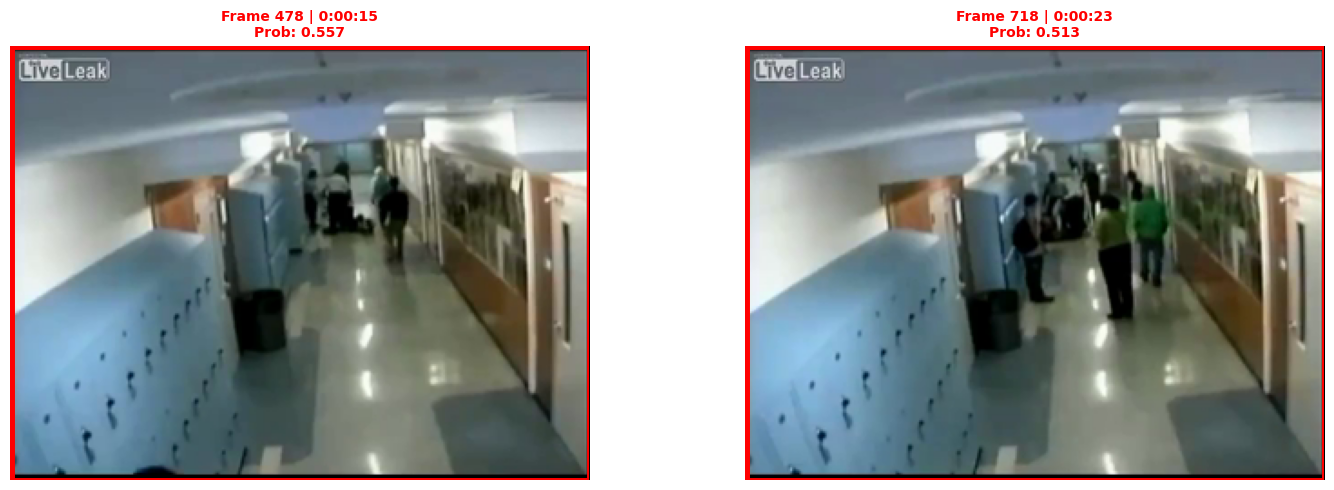

: 

In [ ]:
# =============================================================================
# Extract Key Frames
# =============================================================================
def extract_key_frames(video_path: Path, predictions: List[Dict], max_frames: int = 6):
    """Extract and display key frames where anomalies were detected"""
    
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"Cannot open video: {video_path}")
        return
    
    anomaly_preds = [p for p in predictions if p['prediction'] == 'Anomaly']
    
    if not anomaly_preds:
        print("No anomalies detected")
        cap.release()
        return
    
    if len(anomaly_preds) > max_frames:
        indices = np.linspace(0, len(anomaly_preds)-1, max_frames, dtype=int)
        anomaly_preds = [anomaly_preds[i] for i in indices]
    
    frames_data = []
    for pred in anomaly_preds:
        frame_num = pred['frame']
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames_data.append({
                'frame': frame_rgb,
                'frame_num': frame_num,
                'timestamp': pred['timestamp'],
                'probability': pred['probability']
            })
    
    cap.release()
    
    if not frames_data:
        print("Could not extract frames")
        return
    
    n_frames = len(frames_data)
    cols = min(3, n_frames)
    rows = (n_frames + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if n_frames == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if rows > 1 else axes
    
    for i, data in enumerate(frames_data):
        ax = axes[i]
        ax.imshow(data['frame'])
        ax.set_title(f"Frame {data['frame_num']} | {data['timestamp']}\nProb: {data['probability']:.3f}", 
                    fontsize=10, color='red', weight='bold')
        ax.axis('off')
        
        rect = patches.Rectangle((0, 0), data['frame'].shape[1], data['frame'].shape[0],
                                linewidth=5, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    for i in range(n_frames, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    
    output_path = REPORTS_DIR / f'frames_{video_path.stem}.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f' Saved: {output_path}')
    
    plt.show()

# Extract frames
if results:
    for result in results:
        if result['anomaly_count'] > 0:
            print(f'\n Extracting frames: {result["video_name"]}')
            extract_key_frames(Path(result['video_path']), result['predictions'])

---
##  Complete!

Post-event inference selesai. Check output di:
- **Annotated videos**: `DatasetTA/project_data/post_event_results/annotated_videos/`
- **Reports**: `DatasetTA/project_data/post_event_results/reports/`